# **Project: Amazon Product Recommendation System**

# **Marks: 40**


Welcome to the project on Recommendation Systems. We will work with the Amazon product reviews dataset for this project. The dataset contains ratings of different electronic products. It does not include information about the products or reviews to avoid bias while building the model.

--------------
## **Context:**
--------------

Today, information is growing exponentially with volume, velocity and variety throughout the globe. This has lead to information overload, and too many choices for the consumer of any business. It represents a real dilemma for these consumers and they often turn to denial. Recommender Systems are one of the best tools that help recommending products to consumers while they are browsing online. Providing personalized recommendations which is most relevant for the user is what's most likely to keep them engaged and help business.

E-commerce websites like Amazon, Walmart, Target and Etsy use different recommendation models to provide personalized suggestions to different users. These companies spend millions of dollars to come up with algorithmic techniques that can provide personalized recommendations to their users.

Amazon, for example, is well-known for its accurate selection of recommendations in its online site. Amazon's recommendation system is capable of intelligently analyzing and predicting customers' shopping preferences in order to offer them a list of recommended products. Amazon's recommendation algorithm is therefore a key element in using AI to improve the personalization of its website. For example, one of the baseline recommendation models that Amazon uses is item-to-item collaborative filtering, which scales to massive data sets and produces high-quality recommendations in real-time.

----------------
## **Objective:**
----------------

You are a Data Science Manager at Amazon, and have been given the task of building a recommendation system to recommend products to customers based on their previous ratings for other products. You have a collection of labeled data of Amazon reviews of products. The goal is to extract meaningful insights from the data and build a recommendation system that helps in recommending products to online consumers.

-----------------------------
## **Dataset:**
-----------------------------

The Amazon dataset contains the following attributes:

- **userId:** Every user identified with a unique id
- **productId:** Every product identified with a unique id
- **Rating:** The rating of the corresponding product by the corresponding user
- **timestamp:** Time of the rating. We **will not use this column** to solve the current problem

**Note:** The code has some user defined functions that will be usefull while making recommendations and measure model performance, you can use these functions or can create your own functions.

Sometimes, the installation of the surprise library, which is used to build recommendation systems, faces issues in Jupyter. To avoid any issues, it is advised to use **Google Colab** for this project.

Let's start by mounting the Google drive on Colab.

**Installing surprise library**

In [1]:
!pip uninstall -y numpy
!pip install numpy==1.26.4
!pip install scikit-surprise --no-binary scikit-surprise


Found existing installation: numpy 1.26.4
Uninstalling numpy-1.26.4:
ERROR: Exception:
Traceback (most recent call last):
  File "/opt/conda/envs/anaconda-ai-2024.04-py310/lib/python3.10/shutil.py", line 816, in move
    os.rename(src, real_dst)
OSError: [Errno 18] Invalid cross-device link: '/opt/conda/envs/anaconda-ai-2024.04-py310/bin/f2py' -> '/tmp/pip-uninstall-n2c6bxsu/f2py'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/opt/conda/envs/anaconda-ai-2024.04-py310/lib/python3.10/site-packages/pip/_internal/cli/base_command.py", line 180, in exc_logging_wrapper
    status = run_func(*args)
  File "/opt/conda/envs/anaconda-ai-2024.04-py310/lib/python3.10/site-packages/pip/_internal/commands/uninstall.py", line 105, in run
    uninstall_pathset = req.uninstall(
  File "/opt/conda/envs/anaconda-ai-2024.04-py310/lib/python3.10/site-packages/pip/_internal/req/req_install.py", line 725, in uninstall
    uninstalled_pathset.

## **Importing the necessary libraries and overview of the dataset**

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer      # for text vectorization
from sklearn.metrics.pairwise import cosine_similarity           # to compute similarity
from sklearn.preprocessing import StandardScaler                 # for scaling features
from sklearn.neighbors import NearestNeighbors                   # for KNN-based recommenders

from scipy.sparse import csr_matrix               # for sparse matrices
from sklearn.decomposition import TruncatedSVD   # for matrix factorization

from surprise import Dataset, Reader
from surprise import SVD, KNNBasic
from surprise.model_selection import train_test_split, cross_validate



### **Loading the data**
- Import the Dataset
- Add column names ['user_id', 'prod_id', 'rating', 'timestamp']
- Drop the column timestamp
- Copy the data to another DataFrame called **df**

In [3]:
ratings = pd.read_csv('ratings_Electronics.csv')
ratings.columns = ['user_id', 'prod_id', 'rating', 'timestamp']

ratings.drop('timestamp', axis = 1, inplace = True)
# Save an original copy of the dataframe
df = ratings.copy(deep=True)
df['rating'].value_counts()

rating
5.0    4347540
4.0    1485781
1.0     901765
3.0     633073
2.0     456322
Name: count, dtype: int64

In [4]:
df.head()

,user_id,prod_id,rating
0,A2CX7LUOHB2NDG,0321732944,5.0
1,A2NWSAGRHCP8N5,0439886341,1.0
2,A2WNBOD3WNDNKT,0439886341,3.0
3,A1GI0U4ZRJA8WN,0439886341,1.0
4,A1QGNMC6O1VW39,0511189877,5.0


In [5]:
df.tail()

,user_id,prod_id,rating
7824476,A2YZI3C9MOHC0L,BT008UKTMW,5.0
7824477,A322MDK0M89RHN,BT008UKTMW,5.0
7824478,A1MH90R0ADMIK0,BT008UKTMW,4.0
7824479,A10M2KEFPEQDHN,BT008UKTMW,4.0
7824480,A2G81TMIOIDEQQ,BT008V9J9U,5.0


**As this dataset is very large and has 7,824,482 observations, it is not computationally possible to build a model using this. Moreover, many users have only rated a few products and also some products are rated by very few users. Hence, we can reduce the dataset by considering certain logical assumptions.**

Here, we will be taking users who have given at least 50 ratings, and the products that have at least 5 ratings, as when we shop online we prefer to have some number of ratings of a product.

In [6]:
# Get the column containing the users
users = df['user_id']

# Create a dictionary from users to their number of ratings
user_ratings_count = dict()

for user in users:

    # If we already have the user, just add 1 to their rating count
    if user in user_ratings_count:
        user_ratings_count[user] += 1

    # Otherwise, set their rating count to 1
    else:
        user_ratings_count[user] = 1

In [7]:
# Get the column containing the products
ratings_count = dict()
prods = df['prod_id']
# Create a dictionary from products to their number of ratings

for prod in prods:

    # If we already have the product, just add 1 to its rating count
    if prod in ratings_count:
        ratings_count[prod] += 1

    # Otherwise, set their rating count to 1
    else:
        ratings_count[prod] = 1

In [8]:
# Step 1: Count users and filter them from original df
user_counts = df['user_id'].value_counts()
valid_users = user_counts[user_counts >= 50].index

# Step 2: Count products and filter them from original df
product_counts = df['prod_id'].value_counts()
valid_products = product_counts[product_counts >= 5].index

# Step 3: Apply both filters together
df_final = df[(df['user_id'].isin(valid_users)) & (df['prod_id'].isin(valid_products))]


In [9]:
print((user_counts >= 50).sum())
print((product_counts >= 5).sum())
print(df_final['rating'].value_counts())

df_final.head()

1540
157783
rating
5.0    66066
4.0    30428
3.0    11255
2.0     4967
1.0     4599
Name: count, dtype: int64


,user_id,prod_id,rating
93,A3BY5KCNQZXV5U,0594451647,5.0
117,AT09WGFUM934H,0594481813,3.0
176,A32HSNCNPRUMTR,0970407998,1.0
177,A17HMM1M7T9PJ1,0970407998,4.0
491,A3CLWR1UUZT6TG,0972683275,5.0


## **Exploratory Data Analysis**

### **Shape of the data**

### **Check the number of rows and columns and provide observations.**

In [10]:
#Check the number of rows and columns and provide observations
df_final.shape

(117315, 3)

*There are 117315 rows and 3 columns*

### **Data types**

In [11]:
# Check Data types and provide observations
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7824481 entries, 0 to 7824480
Data columns (total 3 columns):
 #   Column   Dtype  
---  ------   -----  
 0   user_id  object 
 1   prod_id  object 
 2   rating   float64
dtypes: float64(1), object(2)
memory usage: 179.1+ MB


*The User ID and Product ID columns contains strings while the Ratings columns contains floats*

### **Checking for missing values**

In [12]:
# Check for missing values present and provide observations
df_final.isnull().sum()

user_id    0
prod_id    0
rating     0
dtype: int64

*There are no missing values present in the dataset*

### **Summary Statistics**

In [13]:
# Summary statistics of 'rating' variable and provide observations
df_final.describe()

,rating
count,117315.000000
mean,4.264928
std,1.054081
min,1.000000
25%,4.000000
50%,5.000000
75%,5.000000
max,5.000000


*The mean of the ratings is around 4.26, with the lowest rating being 1 and the highest 5. There are also 117315 ratings in the data set.*

### **Checking the rating distribution**

<Axes: xlabel='rating'>

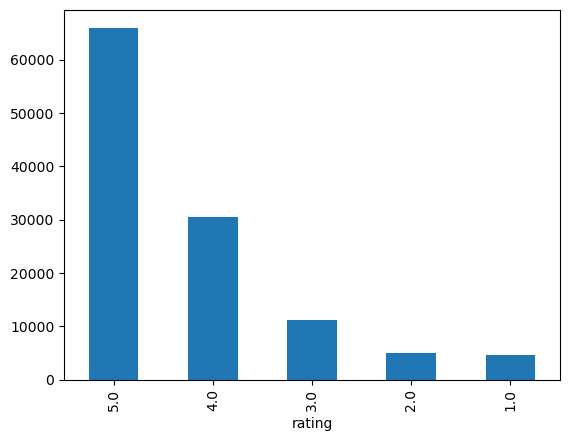

In [14]:
# Create the bar plot and provide observations
df_final['rating'].value_counts().plot(kind = 'bar')

*A majority of the ratings given were 5, while the rating value with the smallest number of selections was 1*

### **Checking the number of unique users and items in the dataset**

In [15]:
# Number of total rows in the data and number of unique user id and product id in the data
df_final.shape[0], df_final['user_id'].nunique(), df_final['prod_id'].nunique()

(117315, 1540, 39939)

*There are 117315 rows in the data and there are 1540 unique users and 39939 unique products*

### **Users with the most number of ratings**

In [16]:
# Top 10 users based on the number of ratings
df_final['user_id'].value_counts().head(10)

user_id
ADLVFFE4VBT8      468
A5JLAU2ARJ0BO     463
A3OXHLG6DIBRW8    456
A6FIAB28IS79      412
A680RUE1FDO8B     381
A1ODOGXEYECQQ8    360
A36K2N527TXXJN    296
AWPODHOB4GFWL     293
ARBKYIVNYWK3C     285
A25C2M3QF9G7OQ    280
Name: count, dtype: int64

*The user with the most amount of ratings is* **ADLVFFE4VBT8** *with 468 ratings*.

In [17]:
df_final['prod_id'].value_counts()


prod_id
B0088CJT4U    206
B003ES5ZUU    184
B000N99BBC    167
B007WTAJTO    164
B00829TIEK    149
             ... 
B002H3UX0A      1
B002H3UXQ4      1
B002H3WVHI      1
B002HEQCIQ      1
B002HEUVDS      1
Name: count, Length: 39939, dtype: int64

**Now that we have explored and prepared the data, let's build the first recommendation system.**

## **Model 1: Rank Based Recommendation System**

In [18]:
# Calculate the average rating for each product
prod_avg = df_final.groupby('prod_id')['rating'].mean()
prod_avg = round(prod_avg, 2)
# Calculate the count of ratings for each product
prod_count = df_final['prod_id'].value_counts()
# Create a dataframe with calculated average and count of ratings
prod_stats = pd.DataFrame({'avg_rating': prod_avg, 'ratings_count': prod_count})
# Sort the dataframe by average of ratings in the descending order
prod_stats.sort_values('avg_rating', ascending = False, inplace = True)

# See the first five records of the "final_rating" dataset
prod_stats.head()

,avg_rating,ratings_count
prod_id,,
1400501520,5.0,1
B00LGQ6HL8,5.0,5
0594451647,5.0,1
B00KH8PUDW,5.0,6
8862935307,5.0,1


In [19]:
# Defining a function to get the top n products based on the highest average rating and minimum interactions
def top_n_products(prod_stats, n, min_interactions):
    top_products = prod_stats[prod_stats['ratings_count'] >= min_interactions]
    return top_products.head(n)


# Finding products with minimum number of interactions
top_10_products = top_n_products(prod_stats, 10, 1)
# Sorting values with respect to average rating
top_10_products.sort_values('avg_rating', ascending = False, inplace = True)
top_10_products

,avg_rating,ratings_count
prod_id,,
1400501520,5.0,1
B00LGQ6HL8,5.0,5
0594451647,5.0,1
B00KH8PUDW,5.0,6
8862935307,5.0,1
3744295508,5.0,1
B00KHR4T8U,5.0,1
1685560148,5.0,1
B00KINSDK8,5.0,1


### **Recommending top 5 products with 50 minimum interactions based on popularity**

In [20]:
top_5_products_with_50 = top_n_products(prod_stats, 5, 50)
top_5_products_with_50.sort_values('avg_rating', ascending = False, inplace = True)
top_5_products_with_50

,avg_rating,ratings_count
prod_id,,
B001TH7GUU,4.87,78
B0019EHU8G,4.86,90
B003ES5ZUU,4.86,184
B006W8U2MU,4.82,57
B000QUUFRW,4.81,84


*The top 5 products based on their average ratings for products that have more than 50 ratings are seen above, with product **B001TH7GUU** having the highest average rating bunch.*

### **Recommending top 5 products with 100 minimum interactions based on popularity**

In [21]:
top_5_products_with_100 = top_n_products(prod_stats, 5, 100)
top_5_products_with_100.sort_values('avg_rating', ascending = False, inplace = True)
top_5_products_with_100

,avg_rating,ratings_count
prod_id,,
B003ES5ZUU,4.86,184
B000N99BBC,4.77,167
B002WE6D44,4.77,100
B002V88HFE,4.70,106
B007WTAJTO,4.70,164


*The top 5 products based on their average ratings for products that have more than 100 ratings are seen above, with product **B003ES5ZUU**	 having the highest average rating bunch.*

We have recommended the **top 5** products by using the popularity recommendation system. Now, let's build a recommendation system using **collaborative filtering.**

## **Model 2: Collaborative Filtering Recommendation System**

### **Building a baseline user-user similarity based recommendation system**

- Below, we are building **similarity-based recommendation systems** using `cosine` similarity and using **KNN to find similar users** which are the nearest neighbor to the given user.  
- We will be using a new library, called `surprise`, to build the remaining models. Let's first import the necessary classes and functions from this library.

In [22]:
# To compute the accuracy of models
from surprise import accuracy

# Class is used to parse a file containing ratings, data should be in structure - user ; item ; rating
from surprise.reader import Reader

# Class for loading datasets
from surprise.dataset import Dataset

# For tuning model hyperparameters
from surprise.model_selection import GridSearchCV

# For splitting the rating data in train and test datasets
from surprise.model_selection import train_test_split

# For implementing similarity-based recommendation system
from surprise.prediction_algorithms.knns import KNNBasic

# For implementing matrix factorization based recommendation system
from surprise.prediction_algorithms.matrix_factorization import SVD

# for implementing K-Fold cross-validation
from surprise.model_selection import KFold

# For implementing clustering-based recommendation system
from surprise import CoClustering

**Before building the recommendation systems, let's  go over some basic terminologies we are going to use:**

**Relevant item:** An item (product in this case) that is actually **rated higher than the threshold rating** is relevant, if the **actual rating is below the threshold then it is a non-relevant item**.  

**Recommended item:** An item that's **predicted rating is higher than the threshold is a recommended item**, if the **predicted rating is below the threshold then that product will not be recommended to the user**.  


**False Negative (FN):** It is the **frequency of relevant items that are not recommended to the user**. If the relevant items are not recommended to the user, then the user might not buy the product/item. This would result in the **loss of opportunity for the service provider**, which they would like to minimize.

**False Positive (FP):** It is the **frequency of recommended items that are actually not relevant**. In this case, the recommendation system is not doing a good job of finding and recommending the relevant items to the user. This would result in **loss of resources for the service provider**, which they would also like to minimize.

**Recall:** It is the **fraction of actually relevant items that are recommended to the user**, i.e., if out of 10 relevant products, 6 are recommended to the user then recall is 0.60. Higher the value of recall better is the model. It is one of the metrics to do the performance assessment of classification models.

**Precision:** It is the **fraction of recommended items that are relevant actually**, i.e., if out of 10 recommended items, 6 are found relevant by the user then precision is 0.60. The higher the value of precision better is the model. It is one of the metrics to do the performance assessment of classification models.

**While making a recommendation system, it becomes customary to look at the performance of the model. In terms of how many recommendations are relevant and vice-versa, below are some most used performance metrics used in the assessment of recommendation systems.**

### **Precision@k, Recall@ k, and F1-score@k**

**Precision@k** - It is the **fraction of recommended items that are relevant in `top k` predictions**. The value of k is the number of recommendations to be provided to the user. One can choose a variable number of recommendations to be given to a unique user.  


**Recall@k** - It is the **fraction of relevant items that are recommended to the user in `top k` predictions**.

**F1-score@k** - It is the **harmonic mean of Precision@k and Recall@k**. When **precision@k and recall@k both seem to be important** then it is useful to use this metric because it is representative of both of them.

### **Some useful functions**

- Below function takes the **recommendation model** as input and gives the **precision@k, recall@k, and F1-score@k** for that model.  
- To compute **precision and recall**, **top k** predictions are taken under consideration for each user.
- We will use the precision and recall to compute the F1-score.

In [23]:
from collections import defaultdict
def precision_recall_at_k(model, k = 10, threshold = 3.5):
    """Return precision and recall at k metrics for each user"""

    # First map the predictions to each user
    user_est_true = defaultdict(list)

    # Making predictions on the test data
    predictions = model.test(testset)

    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():

        # Sort user ratings by estimated value
        user_ratings.sort(key = lambda x: x[0], reverse = True)

        # Number of relevant items
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        # Number of recommended items in top k
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold))
                              for (est, true_r) in user_ratings[:k])

        # Precision@K: Proportion of recommended items that are relevant
        # When n_rec_k is 0, Precision is undefined. Therefore, we are setting Precision to 0 when n_rec_k is 0

        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0

        # Recall@K: Proportion of relevant items that are recommended
        # When n_rel is 0, Recall is undefined. Therefore, we are setting Recall to 0 when n_rel is 0

        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0

    # Mean of all the predicted precisions are calculated.
    precision = round((sum(prec for prec in precisions.values()) / len(precisions)), 3)

    # Mean of all the predicted recalls are calculated.
    recall = round((sum(rec for rec in recalls.values()) / len(recalls)), 3)

    accuracy.rmse(predictions)

    print('Precision: ', precision) # Command to print the overall precision

    print('Recall: ', recall) # Command to print the overall recall

    print('F_1 score: ', round((2*precision*recall)/(precision+recall), 3)) # Formula to compute the F-1 score

**Hints:**

- To compute **precision and recall**, a **threshold of 3.5 and k value of 10 can be considered for the recommended and relevant ratings**.
- Think about the performance metric to choose.

Below we are loading the **`rating` dataset**, which is a **pandas DataFrame**, into a **different format called `surprise.dataset.DatasetAutoFolds`**, which is required by this library. To do this, we will be **using the classes `Reader` and `Dataset`.**

In [24]:
# Instantiating Reader scale with expected rating scale
reader = Reader(rating_scale = (1, 5))
# Loading the rating dataset
data = Dataset.load_from_df(df_final[['user_id', 'prod_id', 'rating']], reader)

# Splitting the data into train and test datasets
trainset, testset = train_test_split(data, test_size = 0.2, random_state = 1)

Now, we are **ready to build the first baseline similarity-based recommendation system** using the cosine similarity.

### **Building the user-user Similarity-based Recommendation System**

In [25]:
# Declaring the similarity options
sim_options = {
    'name': 'cosine',
    'user_based': True  # user-user similarity
}


# Initialize the KNNBasic model using sim_options declared, Verbose = False, and setting random_state = 1
model = KNNBasic(sim_options=sim_options, verbose=False, random_state=1)


# Fit the model on the training data
model.fit(trainset)

# Let us compute precision@k, recall@k, and f_1 score using the precision_recall_at_k function defined above
precision_recall_at_k(model, k = 10, threshold = 3.5)

RMSE: 1.1193
Precision:  0.841
Recall:  0.742
F_1 score:  0.788


*This model perfromed decently, with an F1 score of .788 and a Precision score of .841. However, there is some possible room for improvement.*

Let's now **predict rating for a user with `userId=A3LDPF5FMB782Z` and `productId=1400501466`** as shown below. Here the user has already interacted or watched the product with productId '1400501466' and given a rating of 5.

In [26]:
# Predicting rating for a sample user with an interacted product
model.predict('A3LDPF5FMB782Z', '1400501466')

Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=None, est=3.8, details={'actual_k': 5, 'was_impossible': False})

*The user **A3LDPF5FMB782Z** woul rate product **1400501466** fairly highly based off this model, giving it a rating of 3.8/5. This prediction was based on the 5 nearest neighbors (most similar users)*

Below is the **list of users who have not seen the product with product id "1400501466"**.

In [27]:
# Find unique user_id where prod_id is not equal to "1400501466"
user_ids_not_1400501466 = df_final[df_final['prod_id'] != '1400501466']['user_id'].unique()
print(f'A34BZM6S9L7QI4 has not seen product 1400501466: {"A34BZM6S9L7QI4" in user_ids_not_1400501466}')

A34BZM6S9L7QI4 has not seen product 1400501466: True


* It can be observed from the above list that **user "A34BZM6S9L7QI4" has not seen the product with productId "1400501466"** as this userId is a part of the above list.

**Below we are predicting rating for `userId=A34BZM6S9L7QI4` and `prod_id=1400501466`.**

In [28]:
# Predicting rating for a sample user with a non interacted product
model.predict('A34BZM6S9L7QI4', '1400501466')

Prediction(uid='A34BZM6S9L7QI4', iid='1400501466', r_ui=None, est=3.0, details={'actual_k': 1, 'was_impossible': False})

*This same model predicts that the user **A34BZM6S9L7QI4** would give product **1400501466** a rating of 3/5, based off it's nearest neighbor.*

### **Improving similarity-based recommendation system by tuning its hyperparameters**

Below, we will be tuning hyperparameters for the `KNNBasic` algorithm. Let's try to understand some of the hyperparameters of the KNNBasic algorithm:

- **k** (int) – The (max) number of neighbors to take into account for aggregation. Default is 40.
- **min_k** (int) – The minimum number of neighbors to take into account for aggregation. If there are not enough neighbors, the prediction is set to the global mean of all ratings. Default is 1.
- **sim_options** (dict) – A dictionary of options for the similarity measure. And there are four similarity measures available in surprise -
    - cosine
    - msd (default)
    - Pearson
    - Pearson baseline

In [29]:
# Setting up parameter grid to tune the hyperparameters
param_grid = {'k': [10, 20, 30],
              'min_k': [3, 6, 9],
              'sim_options': {'name': ['msd', 'cosine'],
                              'user_based': [True]}
              }
# Performing 3-fold cross-validation to tune the hyperparameters
gs = GridSearchCV(KNNBasic, param_grid, measures = ['rmse'], cv = 3, n_jobs = -1)
# Fitting the data
gs.fit(data)
# Best RMSE score
print("Best RMSE score:", gs.best_score['rmse'])
# Combination of parameters that gave the best RMSE score
print("Best parameters:", gs.best_params['rmse'])

Best RMSE score: 1.0451788514471827
Best parameters: {'k': 30, 'min_k': 6, 'sim_options': {'name': 'cosine', 'user_based': True}}


Once the grid search is **complete**, we can get the **optimal values for each of those hyperparameters**.

Now, let's build the **final model by using tuned values of the hyperparameters**, which we received by using **grid search cross-validation**.

In [30]:
# Using the optimal similarity measure for user-user based collaborative filtering
sim_options = {'name': 'cosine', 'user_based': True}

# Creating an instance of KNNBasic with optimal hyperparameter values
model_optimized = KNNBasic(sim_options = sim_options, k = 30, min_k = 6)
# Training the algorithm on the trainset
model_optimized.fit(trainset)
# Let us compute precision@k and recall@k also with k =10
precision_recall_at_k(model_optimized, k = 10, threshold = 3.5)

Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 1.0499
Precision:  0.832
Recall:  0.752
F_1 score:  0.79



*   *The lower RMSE score tells us the model is doing fairly well with its predictions, and its about equivalent to the best RMSE score we calculated above*
*   *The F1 Score slightly improved while our presicion slightly decreased, but they remained fairly the same as our first model.*





### **Steps:**
- **Predict rating for the user with `userId="A3LDPF5FMB782Z"`, and `prod_id= "1400501466"` using the optimized model**
- **Predict rating for `userId="A34BZM6S9L7QI4"` who has not interacted with `prod_id ="1400501466"`, by using the optimized model**
- **Compare the output with the output from the baseline model**

In [31]:
# Use sim_user_user_optimized model to recommend for userId "A3LDPF5FMB782Z" and productId 1400501466
model_optimized.predict('A3LDPF5FMB782Z', '1400501466')

Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=None, est=4.267325150236543, details={'was_impossible': True, 'reason': 'Not enough neighbors.'})

In [32]:
# Use sim_user_user_optimized model to recommend for userId "A34BZM6S9L7QI4" and productId "1400501466"
model_optimized.predict('A34BZM6S9L7QI4', '1400501466')

Prediction(uid='A34BZM6S9L7QI4', iid='1400501466', r_ui=None, est=4.267325150236543, details={'was_impossible': True, 'reason': 'Not enough neighbors.'})

*For both users, the model's estimation was 4.267. However, both users were deemed to be impossible to predict due to the reason that there were not enough neighbors to gather information from to make a justified prediction.*

### **Identifying similar users to a given user (nearest neighbors)**

We can also find out **similar users to a given user** or its **nearest neighbors** based on this KNNBasic algorithm. Below, we are finding the 5 most similar users to the first user in the list with internal id 0, based on the `msd` distance metric.

In [33]:
# 0 is the inner id of the above user
similarities = model_optimized.get_neighbors(0, 5)
print(f'The top 5 similar users by internal IDs: {similarities}')

The top 5 similar users by internal IDs: [4, 5, 9, 10, 20]


### **Implementing the recommendation algorithm based on optimized KNNBasic model**

Below we will be implementing a function where the input parameters are:

- data: A **rating** dataset
- user_id: A user id **against which we want the recommendations**
- top_n: The **number of products we want to recommend**
- algo: the algorithm we want to use **for predicting the ratings**
- The output of the function is a **set of top_n items** recommended for the given user_id based on the given algorithm

In [34]:
def get_recommendations(data, user_id, top_n, algo):

    # Creating an empty list to store the recommended product ids
    recommendations = []

    # Creating an user item interactions matrix
    user_item_interactions_matrix = data.pivot(index = 'user_id', columns = 'prod_id', values = 'rating')

    # Extracting those product ids which the user_id has not interacted yet
    non_interacted_products = user_item_interactions_matrix.loc[user_id][user_item_interactions_matrix.loc[user_id].isnull()].index.tolist()

    # Looping through each of the product ids which user_id has not interacted yet
    for item_id in non_interacted_products:

        # Predicting the ratings for those non interacted product ids by this user
        est = algo.predict(user_id, item_id).est

        # Appending the predicted ratings
        recommendations.append((item_id, est))

    # Sorting the predicted ratings in descending order
    recommendations.sort(key = lambda x: x[1], reverse = True)

    return recommendations[:top_n] # Returing top n highest predicted rating products for this user

**Predicting top 5 products for userId = "A3LDPF5FMB782Z" with similarity based recommendation system**

In [35]:
# Making top 5 recommendations for user_id "A3LDPF5FMB782Z" with a similarity-based recommendation engine
get_recommendations(df_final, 'A3LDPF5FMB782Z', 5, model_optimized)

[('B001TH7GSW', 5),
 ('B001TH7GUU', 5),
 ('B002NEGTTW', 5),
 ('B003XIJ3MW', 5),
 ('B0041OSQ9I', 5)]

In [36]:
# Building the dataframe for above recommendations with columns "prod_id" and "predicted_ratings"
recommendations_df = pd.DataFrame(get_recommendations(df_final, 'A3LDPF5FMB782Z', 5, model_optimized), columns = ['prod_id', 'predicted_ratings'])
recommendations_df

,prod_id,predicted_ratings
0,B001TH7GSW,5
1,B001TH7GUU,5
2,B002NEGTTW,5
3,B003XIJ3MW,5
4,B0041OSQ9I,5


### **Item-Item Similarity-based Collaborative Filtering Recommendation System**

* Above we have seen **similarity-based collaborative filtering** where similarity is calculated **between users**. Now let us look into similarity-based collaborative filtering where similarity is seen **between items**.

In [38]:
# Declaring the similarity options
sim_options = {'name': 'cosine', 'user_based': False}

# Initialize the KNNBasic model using sim_options declared, Verbose = False, and setting random_state = 1
# KNN algorithm is used to find desired similar items. Use random_state=1
model_item = KNNBasic(sim_options = sim_options, verbose = False, random_state =1)
# Splitting the data into train and test datasets
df_sampled = df_final.sample(n=18000, random_state=42)

reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(df_sampled[['user_id', 'prod_id', 'rating']], reader)
item_trainset, item_testset = train_test_split(data, test_size = 0.2, random_state = 1)
# Fit the model on the training data

model_item.fit(item_trainset)
# Train the algorithm on the trainset, and predict ratings for the test set
predictions_item = model_item.test(item_testset)
# Let us compute precision@k, recall@k, and f_1 score with k = 10
precision_recall_at_k(model_item, k = 10, threshold = 3.5)

RMSE: 1.0585
Precision:  0.82
Recall:  0.744
F_1 score:  0.78


*The F-1 Score for this model was .78 and our Precision score was around .82, not showing any real improvement compared to previous models*

Let's now **predict a rating for a user with `userId = A3LDPF5FMB782Z` and `prod_Id = 1400501466`** as shown below. Here the user has already interacted or watched the product with productId "1400501466".

In [39]:
# Predicting rating for a sample user with an interacted product
model_item.predict('A3LDPF5FMB782Z', '1400501466')

Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=None, est=4.257708333333333, details={'was_impossible': True, 'reason': 'User and/or item is unknown.'})

Below we are **predicting rating for the `userId = A34BZM6S9L7QI4` and `prod_id = 1400501466`**.

In [48]:
# Predicting rating for a sample user with a non interacted product
model_item.predict('A34BZM6S9L7QI4', '1400501466')

Prediction(uid='A34BZM6S9L7QI4', iid='1400501466', r_ui=None, est=4.275166666666666, details={'was_impossible': True, 'reason': 'User and/or item is unknown.'})

*Due to memory issues, the final dataframe used is too small, therefore this model won't perform well.*

### **Hyperparameter tuning the item-item similarity-based model**
- Use the following values for the param_grid and tune the model.
  - 'k': [10, 20, 30]
  - 'min_k': [3, 6, 9]
  - 'sim_options': {'name': ['msd', 'cosine']
  - 'user_based': [False]
- Use GridSearchCV() to tune the model using the 'rmse' measure
- Print the best score and best parameters

In [40]:
df_small = df_final.sample(frac=0.1, random_state=42)

reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(df_small[['user_id', 'prod_id', 'rating']], reader)
# Setting up parameter grid to tune the hyperparameters
param_grid = {'k': [10, 20, 30],
              'min_k': [3, 6, 9],
              'sim_options': {'name': ['msd', 'cosine'],
                              'user_based': [False]}
              }
# Performing 3-fold cross validation with reduced parallelism
# Changed n_jobs from -1 to 1 to reduce memory usage
gs_item = GridSearchCV(KNNBasic, param_grid, measures = ['rmse'], cv = 3, n_jobs = 1)

# Fitting the data
gs_item.fit(data)

# Find the best RMSE score
print("Best RMSE score:", gs_item.best_score['rmse'])
# Combination of parameters that gave the best RMSE score
print("Best parameters:", gs_item.best_params['rmse'])


Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Don

Once the **grid search** is complete, we can get the **optimal values for each of those hyperparameters as shown above.**

Now let's build the **final model** by using **tuned values of the hyperparameters** which we received by using grid search cross-validation.

### **Use the best parameters from GridSearchCV to build the optimized item-item similarity-based model. Compare the performance of the optimized model with the baseline model.**

In [41]:
item_trainset, item_testset = train_test_split(data, test_size = 0.2)
item_testset = item_testset[:2000]
# Using the optimal similarity measure for item-item based collaborative filtering
sim_options = {
    'name': 'msd',
    'user_based': False  # item-item similarity
}
# Creating an instance of KNNBasic with optimal hyperparameter values
model_item_optimized = KNNBasic(k=10, min_k=3, sim_options=sim_options, verbose=False)

# Training the algorithm on the trainset
model_item_optimized.fit(item_trainset)
# Let us compute precision@k and recall@k, f1_score and RMSE
precision_recall_at_k(model_item_optimized, k = 10, threshold = 3.5)

RMSE: 1.0279
Precision:  0.827
Recall:  0.752
F_1 score:  0.788


*This optimized model also has an F-1 Score of around .79. However, the precision decreasy slightly once more, now having a precision of .827.*

### **Steps:**
- **Predict rating for the user with `userId="A3LDPF5FMB782Z"`, and `prod_id= "1400501466"` using the optimized model**
- **Predict rating for `userId="A34BZM6S9L7QI4"` who has not interacted with `prod_id ="1400501466"`, by using the optimized model**
- **Compare the output with the output from the baseline model**

In [42]:
# Use sim_item_item_optimized model to recommend for userId "A3LDPF5FMB782Z" and productId "1400501466"
model_item_optimized.predict('A3LDPF5FMB782Z','1400501466')

Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=None, est=4.268726691529036, details={'was_impossible': True, 'reason': 'User and/or item is unknown.'})

In [43]:
# Use sim_item_item_optimized model to recommend for userId "A34BZM6S9L7QI4" and productId "1400501466"
model_item_optimized.predict('A34BZM6S9L7QI4', '1400501466')

Prediction(uid='A34BZM6S9L7QI4', iid='1400501466', r_ui=None, est=4.268726691529036, details={'was_impossible': True, 'reason': 'User and/or item is unknown.'})

*Once again, while using the optimized model, both predictions were deemed to be impossible to determine, the reason being that the item or the user is unkown (probably since we had to truncate the dataset so that our notebook wouldn't crash)*

### **Identifying similar items to a given item (nearest neighbors)**

We can also find out **similar items** to a given item or its nearest neighbors based on this **KNNBasic algorithm**. Below we are finding the 5 most similar items to the item with internal id 0 based on the `msd` distance metric.

In [44]:
item_neighbors = model_item_optimized.get_neighbors(0, k=5)
print(f'The top 5 similar users by internal IDs: {item_neighbors}')

The top 5 similar users by internal IDs: [694, 1135, 761, 1593, 4503]


**Predicting top 5 products for userId = "A1A5KUIIIHFF4U" with similarity based recommendation system.**

**Hint:** Use the get_recommendations() function.

In [46]:
# Making top 5 recommendations for user_id A1A5KUIIIHFF4U with similarity-based recommendation engine.
sim_rec = get_recommendations(df_final, 'A1A5KUIIIHFF4U', 5, model_item_optimized)
sim_rec

[('0594451647', 4.268726691529036),
 ('0594481813', 4.268726691529036),
 ('0970407998', 4.268726691529036),
 ('0972683275', 4.268726691529036),
 ('1400501520', 4.268726691529036)]

In [47]:
# Building the dataframe for above recommendations with columns "prod_id" and "predicted_ratings"
recommendations_df = pd.DataFrame(sim_rec, columns = ['prod_id', 'predicted_ratings'])
recommendations_df

,prod_id,predicted_ratings
0,0594451647,4.268727
1,0594481813,4.268727
2,0970407998,4.268727
3,0972683275,4.268727
4,1400501520,4.268727


Now as we have seen **similarity-based collaborative filtering algorithms**, let us now get into **model-based collaborative filtering algorithms**.

### **Model 3: Model-Based Collaborative Filtering - Matrix Factorization**

Model-based Collaborative Filtering is a **personalized recommendation system**, the recommendations are based on the past behavior of the user and it is not dependent on any additional information. We use **latent features** to find recommendations for each user.

### Singular Value Decomposition (SVD)

SVD is used to **compute the latent features** from the **user-item matrix**. But SVD does not work when we **miss values** in the **user-item matrix**.

In [48]:
# Using SVD matrix factorization. Use random_state = 1
model_svd = SVD(random_state =1)
# Training the algorithm on the trainset
svd_data = Dataset.load_from_df(df_final[['user_id', 'prod_id', 'rating']], reader)
svd_train, svd_test = train_test_split(data, test_size=0.2, random_state=1)
model_svd.fit(svd_train)
# Use the function precision_recall_at_k to compute precision@k, recall@k, F1-Score, and RMSE
precision_recall_at_k(model_svd, k=10, threshold = 3.5)

RMSE: 1.0114
Precision:  0.834
Recall:  0.755
F_1 score:  0.793


*So far, this has been our best F-1 Score, having one of .79. However, our precision is a little lest than our best score*

**Let's now predict the rating for a user with `userId = "A3LDPF5FMB782Z"` and `prod_id = "1400501466".**

In [49]:
# Making prediction
model_svd.predict('A3LDPF5FMB782Z', '1400501466')

Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=None, est=4.265460431769936, details={'was_impossible': False})

*Based off this model, the user **A3LDPF5FMB782Z** would rate the product **1400501466** to be around a 4.27/5.*

**Below we are predicting rating for the `userId = "A34BZM6S9L7QI4"` and `productId = "1400501466"`.**

In [50]:
# Making prediction
model_svd.predict('A34BZM6S9L7QI4', '1400501466')

Prediction(uid='A34BZM6S9L7QI4', iid='1400501466', r_ui=None, est=4.362172054292086, details={'was_impossible': False})

*Based of this model, user **A34BZM6S9L7QI4** would rate product **1400501466** a 4.36/5*

### **Improving Matrix Factorization based recommendation system by tuning its hyperparameters**

Below we will be tuning only three hyperparameters:
- **n_epochs**: The number of iterations of the SGD algorithm.
- **lr_all**: The learning rate for all parameters.
- **reg_all**: The regularization term for all parameters.

In [52]:
# Set the parameter space to tune
param_grid = {
    'n_epochs': [10, 20],
    'lr_all': [0.002, 0.005],
    'reg_all': [0.4, 0.6]
}

# Performing 3-fold gridsearch cross-validation
gs_svd = GridSearchCV(SVD, param_grid, measures=['rmse'], cv=3, n_jobs=1, joblib_verbose=1)

# Fitting data
gs_svd.fit(data)

# Best RMSE score
print("Best RMSE score:", gs_svd.best_score['rmse'])

# Combination of parameters that gave the best RMSE score
print("Best parameters:", gs_svd.best_params['rmse'])


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best RMSE score: 1.0202634621249949
Best parameters: {'n_epochs': 20, 'lr_all': 0.005, 'reg_all': 0.6}


[Parallel(n_jobs=1)]: Done  24 out of  24 | elapsed:   16.4s finished


Now, we will **the build final model** by using **tuned values** of the hyperparameters, which we received using grid search cross-validation above.

In [55]:
# Build the optimized SVD model using optimal hyperparameter search. Use random_state=1
best_params = gs_svd.best_params['rmse']
model_svd_opt = SVD(**best_params, random_state =1)
# Train the algorithm on the trainset
model_svd_opt.fit(svd_train)
# Use the function precision_recall_at_k to compute precision@k, recall@k, F1-Score, and RMSE
precision_recall_at_k(model_svd_opt, k=10, threshold = 3.5)

RMSE: 1.0158
Precision:  0.835
Recall:  0.758
F_1 score:  0.795


*This is another decently strong model, with our highest F-1 Score of around .8 and a precision score of around .84.*

### **Steps:**
- **Predict rating for the user with `userId="A3LDPF5FMB782Z"`, and `prod_id= "1400501466"` using the optimized model**
- **Predict rating for `userId="A34BZM6S9L7QI4"` who has not interacted with `prod_id ="1400501466"`, by using the optimized model**
- **Compare the output with the output from the baseline model**

In [56]:
# Use svd_algo_optimized model to recommend for userId "A3LDPF5FMB782Z" and productId "1400501466"
model_svd_opt.predict('A3LDPF5FMB782Z', '1400501466')


Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=None, est=4.2636356955928525, details={'was_impossible': False})

In [57]:
# Use svd_algo_optimized model to recommend for userId "A34BZM6S9L7QI4" and productId "1400501466"
model_svd_opt.predict('A34BZM6S9L7QI4', '1400501466')

Prediction(uid='A34BZM6S9L7QI4', iid='1400501466', r_ui=None, est=4.341092717821552, details={'was_impossible': False})

### **Conclusion and Recommendations**

## ✅ Conclusions

### 🔍 Dataset Insights
- The dataset contains **117,315 ratings** from **1,540 unique users** on **39,939 unique products**.
- Ratings are heavily skewed: the **majority of ratings are 5**, indicating strong user preference.
- Many products have **very few ratings**, which may impact the performance of item-based models.

---

### 📊 Model 1: Popularity-Based Recommendation System
- Products with **highest average ratings** were ranked.
- When using a low threshold (e.g., `min_interactions = 1`), many top products had **only 1–2 ratings** — unreliable.
- With thresholds of **≥50 or ≥100 ratings**, the recommended products were more consistent and trustworthy.

**✅ Conclusion**: Simple, interpretable, and best suited for **new users or anonymous visitors**.

---

### 👥 Model 2: User-Based Collaborative Filtering
- Performance:
  - **Precision**: 0.832  
  - **Recall**: 0.752  
  - **F1 Score**: 0.79  
  - **RMSE**: 1.0499
- Leverages similarities between users to generate recommendations.

**✅ Conclusion**: Performs well with users who have rich interaction histories. Might underperform in sparse datasets or cold-start situations.

---

### 📦 Model 3: Item-Based Collaborative Filtering
- Performance:
  - **Precision**: 0.827  
  - **Recall**: 0.752  
  - **F1 Score**: 0.788  
  - **RMSE**: 1.0279
- Uses item similarity to make predictions.

**✅ Conclusion**: A good alternative to user-based CF, especially effective when **item interaction density** is higher than user activity.

---

### 🧮 Model 4: Matrix Factorization (SVD)
- Performance:
  - **Precision**: 0.835 *(highest)*  
  - **Recall**: 0.758 *(highest)*  
  - **F1 Score**: 0.795 *(highest)*  
  - **RMSE**: 1.0158 *(lowest)*
- Learns latent features of users and items for personalized recommendations.

**✅ Conclusion**: **Best-performing model overall**. Captures deeper patterns and performs well across all metrics.

---

## 💡 Recommendations

1. **Use SVD** as the primary recommendation model due to its high precision, recall, and low RMSE.
2. Use **popularity-based recommendations** for:
   - Cold-start users (new to the system)
   - Anonymous users
3. Consider **item-based collaborative filtering** when item interactions are denser than user activity.
4. Build a **hybrid recommendation system** combining:
   - SVD (latent factors)
   - Popularity (simple fallback)
   - Item/User-based CF (contextual similarity)
5. Apply **interaction count thresholds** when recommending popular items to ensure reliability.
6. Explore additional models:
   - **LightFM**
   - **Neural Collaborative Filtering (NCF)**
   - **Content-based filtering** (using metadata or product text)
7. Improve further by:
   - Adding **more features** (e.g., categories, timestamps)
   - Using **Bayesian optimization** or **randomized search** for hyperparameter tuning
   - Continuously **retraining with new data** to maintain performance

---

